# Tutorial - Step2 : MTMR finetuning with Reinforcement learning

## 1. Import requirements

In [1]:
import os
import sys
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt

In [2]:
sys.path = [os.path.abspath(os.path.join(os.getcwd(), os.pardir))] + sys.path

In [3]:
from MTMR.dataset import TrainingSmilesDataset, ValidationSmilesDataset
from MTMR.vae import SmilesAutoencoder, RewardFunctionLogP
from MTMR.properties import penalized_logp, similarity

## 2. Configure GPU (if available)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## 3. Specify a target property

In [5]:
PROPERTY_NAME = "logp06"

SCORING_PROPERTY_FT = penalized_logp
SCORING_TANIMOTO_FT = similarity

## Configure the parameters of a reward function for the target property
threshold_property = 0.
threshold_similarity = 0.5

## 4. Set directories (for inputs and outputs)

In [6]:
input_data_dir = os.path.abspath(os.path.join(os.pardir, "DATA", PROPERTY_NAME))
input_ckpt_dir = f"outputs_3-1_{PROPERTY_NAME.upper()}_pretraining"

In [7]:
output_dir = f"outputs_3-2_{PROPERTY_NAME.upper()}_finetuning"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 5. Set file names

In [7]:
filepath_train = os.path.join(input_data_dir, "rdkit_train_triplet.txt")
filepath_valid = os.path.join(input_data_dir, "rdkit_valid.txt")

In [8]:
filepath_pretrain_ckpt     = os.path.join(input_ckpt_dir, "checkpoints.pt")
filepath_pretrain_configs  = os.path.join(input_ckpt_dir, "configs.csv")
filepath_pretrain_char2idx = os.path.join(input_ckpt_dir, "char2idx.csv")

In [9]:
filepath_char2idx      = os.path.join(output_dir, "char2idx.csv")
filepath_configs       = os.path.join(output_dir, "configs.csv")
filepath_checkpoint    = os.path.join(output_dir, "checkpoints.pt")
filepath_history       = os.path.join(output_dir, "history.csv")
filepath_history_valid = os.path.join(output_dir, "history_valid.csv")

## 6. Load datasets (for training and validation)

In [10]:
dataset = TrainingSmilesDataset(filepath_train, filepath_char2idx=filepath_pretrain_char2idx, device=device)
dataset.save_char2idx(filepath_char2idx)
dataset_valid = ValidationSmilesDataset(filepath_valid, filepath_char2idx, device=device)

## 7. Load a pretrained generator of MTMR

In [11]:
## Model configuration
model_configs = {"hidden_size"    :None,
                 "latent_size"    :None,
                 "num_layers"     :None,
                 "vocab_size"     :None,
                 "sos_idx"        :None,
                 "eos_idx"        :None,
                 "pad_idx"        :None,
                 "device"         :device,
                 "filepath_config":filepath_pretrain_configs}

## Model initialization
generator = SmilesAutoencoder(**model_configs)

## Load pretrained model
generator.load_model(filepath_pretrain_ckpt)

## Configuration save
generator.save_config(filepath_configs)

## 8. Define a reward function

In [12]:
reward_ft = RewardFunctionLogP(similarity_ft=SCORING_TANIMOTO_FT,
                               scoring_ft=SCORING_PROPERTY_FT,
                               threshold_property=threshold_property,
                               threshold_similarity=threshold_similarity)

## 9. Train

In [13]:
df_history, df_history_valid = generator.policy_gradient(dataset, reward_ft,
                                                         validation_dataset=dataset_valid,
                                                         checkpoint_filepath=filepath_checkpoint)

df_history.to_csv(filepath_history, index=False)
df_history_valid.to_csv(filepath_history_valid, index=False)

[000000/002000]  loss: 0.279  reward: 1.124  similarity: 0.674  property[0]: 1.124  valid_ratio(va): 0.945  similarity(va): 0.419  property(va): 1.214
[000010/002000]  loss: 0.191  reward: 1.502  similarity: 0.668  property[0]: 1.502  valid_ratio(va): 0.985  similarity(va): 0.429  property(va): 1.891
[000020/002000]  loss: 0.180  reward: 1.674  similarity: 0.671  property[0]: 1.674  valid_ratio(va): 0.995  similarity(va): 0.411  property(va): 2.462
[000030/002000]  loss: 0.193  reward: 1.817  similarity: 0.655  property[0]: 1.817  valid_ratio(va): 0.990  similarity(va): 0.400  property(va): 2.819
[000040/002000]  loss: 0.174  reward: 1.810  similarity: 0.673  property[0]: 1.810  valid_ratio(va): 1.000  similarity(va): 0.404  property(va): 2.860
[000050/002000]  loss: 0.179  reward: 1.797  similarity: 0.655  property[0]: 1.797  valid_ratio(va): 1.000  similarity(va): 0.407  property(va): 2.890
[000060/002000]  loss: 0.182  reward: 1.931  similarity: 0.660  property[0]: 1.931  valid_rati

[000550/002000]  loss: 0.191  reward: 2.007  similarity: 0.651  property[0]: 2.007  valid_ratio(va): 1.000  similarity(va): 0.418  property(va): 3.046
[000560/002000]  loss: 0.200  reward: 2.156  similarity: 0.651  property[0]: 2.156  valid_ratio(va): 1.000  similarity(va): 0.408  property(va): 3.122
[000570/002000]  loss: 0.165  reward: 2.438  similarity: 0.668  property[0]: 2.438  valid_ratio(va): 1.000  similarity(va): 0.418  property(va): 3.117
[000580/002000]  loss: 0.172  reward: 2.301  similarity: 0.669  property[0]: 2.301  valid_ratio(va): 1.000  similarity(va): 0.412  property(va): 3.049
[000590/002000]  loss: 0.173  reward: 2.307  similarity: 0.659  property[0]: 2.307  valid_ratio(va): 1.000  similarity(va): 0.413  property(va): 3.162
[000600/002000]  loss: 0.177  reward: 2.087  similarity: 0.672  property[0]: 2.087  valid_ratio(va): 1.000  similarity(va): 0.411  property(va): 3.122
[000610/002000]  loss: 0.179  reward: 2.220  similarity: 0.657  property[0]: 2.220  valid_rati

[001100/002000]  loss: 0.183  reward: 2.326  similarity: 0.666  property[0]: 2.326  valid_ratio(va): 1.000  similarity(va): 0.421  property(va): 3.150
[001110/002000]  loss: 0.181  reward: 2.281  similarity: 0.675  property[0]: 2.281  valid_ratio(va): 1.000  similarity(va): 0.418  property(va): 3.145
[001120/002000]  loss: 0.165  reward: 2.064  similarity: 0.664  property[0]: 2.064  valid_ratio(va): 1.000  similarity(va): 0.417  property(va): 3.164
[001130/002000]  loss: 0.181  reward: 2.163  similarity: 0.660  property[0]: 2.163  valid_ratio(va): 1.000  similarity(va): 0.414  property(va): 3.231
[001140/002000]  loss: 0.196  reward: 2.636  similarity: 0.675  property[0]: 2.636  valid_ratio(va): 1.000  similarity(va): 0.413  property(va): 3.200
[001150/002000]  loss: 0.173  reward: 2.071  similarity: 0.652  property[0]: 2.071  valid_ratio(va): 1.000  similarity(va): 0.415  property(va): 3.178
[001160/002000]  loss: 0.182  reward: 2.093  similarity: 0.665  property[0]: 2.093  valid_rati

[001650/002000]  loss: 0.174  reward: 2.365  similarity: 0.657  property[0]: 2.365  valid_ratio(va): 1.000  similarity(va): 0.423  property(va): 3.204
[001660/002000]  loss: 0.193  reward: 2.606  similarity: 0.655  property[0]: 2.606  valid_ratio(va): 1.000  similarity(va): 0.426  property(va): 3.167
[001670/002000]  loss: 0.166  reward: 2.245  similarity: 0.667  property[0]: 2.245  valid_ratio(va): 1.000  similarity(va): 0.421  property(va): 3.228
[001680/002000]  loss: 0.165  reward: 2.255  similarity: 0.671  property[0]: 2.255  valid_ratio(va): 1.000  similarity(va): 0.419  property(va): 3.304
[001690/002000]  loss: 0.208  reward: 2.561  similarity: 0.655  property[0]: 2.561  valid_ratio(va): 1.000  similarity(va): 0.415  property(va): 3.316
[001700/002000]  loss: 0.171  reward: 2.246  similarity: 0.664  property[0]: 2.246  valid_ratio(va): 1.000  similarity(va): 0.422  property(va): 3.268
[001710/002000]  loss: 0.182  reward: 2.158  similarity: 0.667  property[0]: 2.158  valid_rati

## 10. Visualize for reward & loss analysis

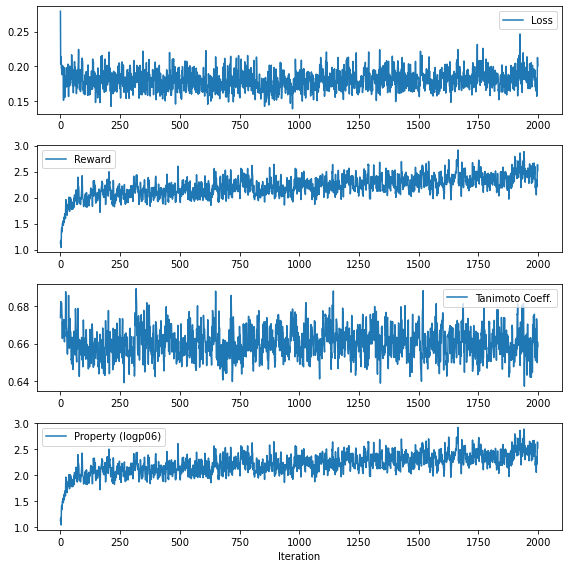

In [14]:
fig, axes = plt.subplots(4,1,figsize=(8,8))

axes[0].plot(df_history.loc[:,"LOSS"], label="Loss")
axes[1].plot(df_history.loc[:,"REWARD"], label="Reward")
axes[2].plot(df_history.loc[:,"SIMILARITY"], label="Tanimoto Coeff.")
axes[3].plot(df_history.loc[:,"PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[3].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

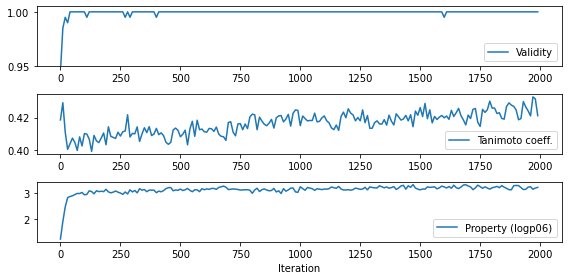

In [15]:
fig, axes = plt.subplots(3,1,figsize=(8,4))

axes[0].plot(df_history_valid.loc[:,"VALID_RATIO"], label="Validity")
axes[1].plot(df_history_valid.loc[:,"AVERAGE_SIMILARITY"], label="Tanimoto coeff.")
axes[2].plot(df_history_valid.loc[:,"AVERAGE_PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[0].set_ylim(0.95, 1.005)

axes[2].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()